In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from scipy import stats
import re

# Data

## Read in data

In [ ]:
# products = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/products_train.csv')
# sessions = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/sessions_train.csv')
products = pd.read_csv('products_train.csv')
sessions = pd.read_csv('sessions_train.csv')

### Overview of data

In [ ]:
products.head()

# IDEA 1:
# Only consider data in English

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [ ]:
sessions.head()

# IDEA 2:
# 1. Only consider sessions in English
# 2. Only consider sessions that has more than certain number of items

,prev_items,next_item,locale
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE


Only want to consider English items and sessions

In [ ]:
products_uk = products.loc[products['locale']=='UK']
products_uk.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
913336,B087LZNPHS,UK,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,127cm×150cm,NaN,100% Polyester,NaN,COLOR: The sherpa throw blanket is available i...
913337,B08THFN1KX,UK,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,240mm x 190mm x 60mm,50245-Mat-Perso,Rubber,NaN,Competitively priced
913338,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN
913339,B09VBKDBW6,UK,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,NaN,FBA-sealer-black,Acrylonitrile Butadiene Styrene,NaN,【AFTER-SALE】This handheld food heat sealer sho...
913340,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,🔐【 Anti-Friction & Customer First】Each box of ...


In [ ]:
sessions_uk = sessions.loc[sessions['locale'] == 'UK']
sessions_uk.head()

,prev_items,next_item,locale
2090535,['B0BFDL54Y7' 'B0BFDR9X13' 'B07J4WF8VH' 'B07Y2...,B07Y227WNJ,UK
2090536,['B07FM2GLNQ' 'B07GZW3P4W'],B095NNZCR6,UK
2090537,['B0021L95HU' 'B07DDL77RY' 'B07DDL77RY'],B002KA1FZC,UK
2090538,['B0B2WSZYL2' 'B000I8XZ7O'],B000I90TAO,UK
2090539,['B00LW1APOC' 'B00LW1APOC' 'B00OI6NQUI' 'B09HL...,B07H54NZ3K,UK


In [ ]:
products_uk.info()

# IDEA 3:
# !!!1. Keep items that has brand & the number of items in that brand is large (how larg, we might decide it later)
# !!!2. Since not too many items do not have color, so we might want to filter out items that does not have color
#       & maybe filter out colors that are not having many items in it
# !!!3. I think material is important for categories, will check it later then decide whether use it
# !!!4. desc, need take a close look => giving strategies to deal with it
# !! 5. Many missing values in size, we can consider whether use size after filter the brand and color
# !  6. Model, not sure how it works, but it probably is more detailed info for that brand
#    7. Only miss 8 titles, not a big deal and it might be filtered out after previous steps
#    8. Author, too many missing value, NOT CONSIDER USING IT

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500180 entries, 913336 to 1413515
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        500180 non-null  object 
 1   locale    500180 non-null  object 
 2   title     500180 non-null  object 
 3   price     500180 non-null  float64
 4   brand     495900 non-null  object 
 5   color     378080 non-null  object 
 6   size      301092 non-null  object 
 7   model     243529 non-null  object 
 8   material  298955 non-null  object 
 9   author    18896 non-null   object 
 10  desc      460922 non-null  object 
dtypes: float64(1), object(10)
memory usage: 45.8+ MB


In [ ]:
sessions_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182181 entries, 2090535 to 3272715
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   prev_items  1182181 non-null  object
 1   next_item   1182181 non-null  object
 2   locale      1182181 non-null  object
dtypes: object(3)
memory usage: 36.1+ MB


### Column EDA

#### Products

In [ ]:
products_uk.columns

Index(['id', 'locale', 'title', 'price', 'brand', 'color', 'size', 'model',
       'material', 'author', 'desc'],
      dtype='object')

In [ ]:
# The total number of English products without filtering
total_products_uk = len(products_uk)
total_products_uk

500180

##### Locale

In [ ]:
products_uk['locale'].value_counts()

# Now filtered to only use UK values

UK    500180
Name: locale, dtype: int64

##### Price

In [ ]:
products_uk['price'].describe()

# TODO 2:
# Filter out those items that are too expensive, only keep price < 100 ?

count    5.001800e+05
mean     2.021694e+06
std      8.762408e+06
min      0.000000e+00
25%      7.990000e+00
50%      1.299000e+01
75%      2.399000e+01
max      4.000000e+07
Name: price, dtype: float64

In [ ]:
max(products_uk.price)

40000000.07

In [ ]:
# Removing outlier prices, don't want to recommend items listed at $40 million
products_uk[products_uk["price"] < max(products_uk["price"])]

,id,locale,title,price,brand,color,size,model,material,author,desc
913336,B087LZNPHS,UK,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,127cm×150cm,NaN,100% Polyester,NaN,COLOR: The sherpa throw blanket is available i...
913337,B08THFN1KX,UK,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,240mm x 190mm x 60mm,50245-Mat-Perso,Rubber,NaN,Competitively priced
913338,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN
913339,B09VBKDBW6,UK,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,NaN,FBA-sealer-black,Acrylonitrile Butadiene Styrene,NaN,【AFTER-SALE】This handheld food heat sealer sho...
913340,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,🔐【 Anti-Friction & Customer First】Each box of ...
...,...,...,...,...,...,...,...,...,...,...,...
1413511,B08D7KW8VK,UK,TOMHOUSEE Anime Cosplay Short Straight Hair Wi...,9.99,TOMHOUSEE,Deep Grey Yuki,NaN,NaN,Synthetic,NaN,NaN
1413512,B073WXLXR9,UK,Crystals NEW brilliant ink twister bingo dabbe...,8.99,CRYSTALS,"Orange,blue,green,pink,red,purple",NaN,NaN,Plastic,NaN,NaN
1413513,1529393833,UK,"Before I Do: the new, funny and unexpected lov...",4.50,Hodder Paperbacks,NaN,NaN,NaN,NaN,"Cousens, Sophie",NaN
1413514,B0B3TJ1NDN,UK,"Black iPhone Charger Cable, iPhone Charger Bra...",4.49,AA-TECH,Black,2M,brd-ip-black-2022,Nylon Braided,NaN,Added Protection: An additional layer of prote...


More than 25,000 rows with max price

In my opinion, it's essential to remove these rows before any kind of modeling

In [ ]:
max(products_uk[products_uk["price"] < max(products_uk["price"])]["price"])

7999.0

Once max price removed, new max price is $8,000

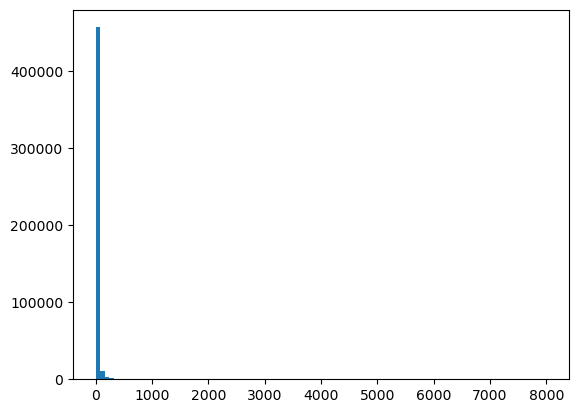

In [ ]:
plt.hist(products_uk[products_uk["price"] < max(products_uk["price"])]["price"], bins=100);

Vast majority of data is well under $500, could think about restricting it further

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<5000000]['price'])

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<500000]['price'])

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<100000]['price'])

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<20000]['price'])

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<2500]['price'])

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<500]['price'])

In [ ]:
# plt.hist(products_uk.loc[products_uk['price']<100]['price'])

##### Brand

In [ ]:
brand_counts = products_uk['brand'].value_counts()
brand_counts # 76349 unique brands

# TODO 3:
# Filter out rare brands

Generic            2283
L'Oreal            1508
Amazon Basics      1402
LEGO               1335
Morrisons          1287
                   ... 
Bookends2pairUK       1
Lipton Iced Tea       1
Q&K                   1
HULY                  1
CRYSTALS              1
Name: brand, Length: 76349, dtype: int64

May want to consider filtering out rare brands

But what is "rare"?

In [ ]:
brand_counts[brand_counts > 100] # 439

Generic          2283
L'Oreal          1508
Amazon Basics    1402
LEGO             1335
Morrisons        1287
                 ... 
ORETECH           101
Olay              101
Pecute            101
JUSTOTRY          101
POPRUN            101
Name: brand, Length: 439, dtype: int64

In [ ]:
brand_counts[brand_counts > 500] # 24

Generic                                      2283
L'Oreal                                      1508
Amazon Basics                                1402
LEGO                                         1335
Morrisons                                    1287
Independently published                      1191
Apple                                        1033
Samsung                                       997
Coty                                          894
Smiffy's                                      842
JETech                                        744
I LOVE FANCY DRESS LTD                        743
Audible                                       678
Amazon EU Sarl                                652
Amazon                                        590
Coordination Group Publications Ltd (CGP)     586
Philips                                       585
Anker                                         549
Spigen                                        539
Hasbro                                        535


In [ ]:
len(brand_counts[brand_counts > 5]) # 17572

17572

##### Color

In [ ]:
color_counts = products_uk['color'].value_counts()
color_counts # 72069

# TODO 5:
# Filter out rare colors.

Black                         56750
White                         33187
Blue                          15002
Grey                          11594
Silver                        10344
                              ...  
Warm White(3m*2m)                 1
Big Tray + Blue Mat               1
B-bead Dark Pink                  1
Four-Leaf Clover Bowl Blue        1
Deep Grey Yuki                    1
Name: color, Length: 72069, dtype: int64

In [ ]:
color_counts[0:50]

Black              56750
White              33187
Blue               15002
Grey               11594
Silver             10344
Multicolor         10153
Red                 8294
Pink                7902
Green               7832
Clear               6956
Brown               6091
Transparent         3664
Purple              3512
Gold                3294
Yellow              3053
Orange              2716
Beige               2605
Multicoloured       2569
Multi               2148
black               1973
Warm White          1836
Gray                1642
Multicolour         1376
Rose Gold           1301
Assorted            1213
white               1176
Navy                1032
Dark Grey           1007
Cream                960
Natural              955
Navy Blue            775
Chrome               756
Multi-colour         683
A                    661
Light Grey           648
Cool White           608
BLACK                606
blue                 563
Charcoal             507
Multi-coloured       496


Column needs some cleaning, bad values present + capitalization issues

In [ ]:
len(color_counts[color_counts > 10000])

6

##### Size

In [ ]:
sum(products_uk['size'].notnull())

301092

In [ ]:
size_notnull = products_uk.loc[products_uk['size'].notnull()]
size_notnull_counts = size_notnull['size'].value_counts()
size_notnull_counts

# TODO 6:
# filter some size out

One Size                         17586
1 Count (Pack of 1)              14423
L                                 5695
M                                 5257
S                                 3933
                                 ...  
2.54 m (Pack of 1)                   1
15L(90Bags)                          1
Shower                               1
Double-Deck                          1
HAT PLUS EPAULETTES AND SCARF        1
Name: size, Length: 74020, dtype: int64

In [ ]:
size_notnull_counts[0:25]

One Size                17586
1 Count (Pack of 1)     14423
L                        5695
M                        5257
S                        3933
2 Count (Pack of 1)      3564
Small                    2504
Large                    2266
Medium                   2240
6 Count (Pack of 1)      2134
Double                   1937
4 Count (Pack of 1)      1913
3 Count (Pack of 1)      1900
100 ml (Pack of 1)       1568
XL                       1476
30 ml (Pack of 1)        1404
10 Count (Pack of 1)     1375
Single                   1366
12 Count (Pack of 1)     1342
250 ml (Pack of 1)       1341
50 ml (Pack of 1)        1301
5 Count (Pack of 1)      1173
200 ml (Pack of 1)       1128
10 ml (Pack of 1)        1125
1                        1118
Name: size, dtype: int64

May also need some cleaning for bad values/spelled out vs abbreviated (L vs Large)

Which sizes actually might matter?

In [ ]:
len(size_notnull_counts[size_notnull_counts > 1000])

29

In [ ]:
len(size_notnull_counts[size_notnull_counts > 10000])

2

##### Model

In [ ]:
sum(products_uk['size'].notnull())

# TODO 7:
# filter some model out

301092

In [ ]:
model_notnull = products_uk.loc[products_uk['model'].notnull()]
model_notnull_counts = model_notnull['model'].value_counts()
model_notnull_counts

1                2675
.                2505
0                 315
001               223
01                196
                 ... 
4DC3                1
GCH00818            1
12426416            1
MPA-CCS-00004       1
711995              1
Name: model, Length: 202106, dtype: int64

My gut says this is not important except in specific circumstances, especially with such a vague model type as "1"

In [ ]:
len(model_notnull_counts[model_notnull_counts > 100])

11

##### Material

In [ ]:
sum(products_uk['material'].notnull())

# TODO 8:
# filter some materials out

298955

In [ ]:
material_notnull = products_uk.loc[products_uk['material'].notnull()]
material_notnull_counts = material_notnull['material'].value_counts()
material_notnull_counts

Plastic                    42638
Metal                      13343
Polyester                  13080
Stainless Steel            10226
Paper                      10029
                           ...  
Gel, Silicone                  1
Polyester + Magnet             1
essential oil set              1
tissue paper                   1
Aluminium,Plastic,Resin        1
Name: material, Length: 14775, dtype: int64

In [ ]:
material_notnull_counts[0:10]

Plastic                            42638
Metal                              13343
Polyester                          13080
Stainless Steel                    10226
Paper                              10029
Cotton                              9552
Silicone                            8508
Wood                                7166
Aluminium                           6752
Rubber                              6716
Glass                               6003
Nylon                               5430
Acrylonitrile Butadiene Styrene     5042
Alloy Steel                         4833
Acrylic                             4289
Faux Leather                        4190
Cardboard                           4102
Leather                             3533
Polypropylene                       3444
100% Polyester                      3158
Polycarbonate                       3129
Polyvinyl Chloride                  3085
Ceramic                             2716
Copper                              2176
Synthetic       

In [ ]:
len(material_notnull_counts[material_notnull_counts > 10000])

5

##### Author

In [ ]:
sum(products_uk['author'].notnull())

# TODO 9:
# delete author column

18896

In [ ]:
products_uk["author"].value_counts()

CGP Books                    577
Donaldson, Julia             126
DK                           106
Various Artists               82
Peppa Pig                     68
                            ... 
Tennant, Tilly                 1
Amanda Michalka                1
Florino, Dania                 1
Various Authors                1
Jackson, Curtis "50 Cent"      1
Name: author, Length: 8417, dtype: int64

May not be necessary for modeling

##### desc

In [ ]:
sum(products_uk['desc'].notnull())

460922

In [ ]:
desc_uk_notnull = products_uk.loc[(products_uk['desc'].notnull())]['desc']

In [ ]:
desc_uk_notnull

913336     COLOR: The sherpa throw blanket is available i...
913337                                  Competitively priced
913339     【AFTER-SALE】This handheld food heat sealer sho...
913340     🔐【 Anti-Friction & Customer First】Each box of ...
913341                                                Horror
                                 ...                        
1413508    Boing rope included: This bird cage comes with...
1413509    Easy to clean ✓ The toilet seat has a special ...
1413510    CONVENIENT: Can be hung from a branch or feedi...
1413514    Added Protection: An additional layer of prote...
1413515    🔵 Mini Pegs : 100 Wooden Pegs For Decoration, ...
Name: desc, Length: 460922, dtype: object

In [ ]:
desc_uk_notnull[913336]

'COLOR: The sherpa throw blanket is available in a variety of colors, being able to meet your individual requirements. With different colors to choose from, you will easily find the suitable throw blanket to coordinate with your decor.'

In [ ]:
desc_uk_notnull[913340]

'🔐【 Anti-Friction & Customer First】Each box of products is equipped with anti-friction lining strips which avoids scratches on the steering wheel during use. Lucosobie must be responsible for any product defects and provides the car steering wheel lock 12-MONTH warranty. It is not just lip service!'

#### Sessions

In [ ]:
sessions_uk.columns

Index(['prev_items', 'next_item', 'locale'], dtype='object')

See total number of UK sessions

In [ ]:
len(sessions_uk)

1182181

In [ ]:
prev_len = list(map(lambda row: len(row.strip('[]').split()), sessions_uk['prev_items']))
sessions_uk['prev_items_len'] = prev_len
sessions_uk.head()

C:\Users\Sovann\AppData\Local\Temp\ipykernel_50648\1271237373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_uk['prev_items_len'] = prev_len


,prev_items,next_item,locale,prev_items_len
2090535,['B0BFDL54Y7' 'B0BFDR9X13' 'B07J4WF8VH' 'B07Y2...,B07Y227WNJ,UK,4
2090536,['B07FM2GLNQ' 'B07GZW3P4W'],B095NNZCR6,UK,2
2090537,['B0021L95HU' 'B07DDL77RY' 'B07DDL77RY'],B002KA1FZC,UK,3
2090538,['B0B2WSZYL2' 'B000I8XZ7O'],B000I90TAO,UK,2
2090539,['B00LW1APOC' 'B00LW1APOC' 'B00OI6NQUI' 'B09HL...,B07H54NZ3K,UK,4


View the longest sessions for potential outliers

In [ ]:
sorted(sessions_uk['prev_items_len'], reverse=True)

[201,
 109,
 99,
 95,
 89,
 88,
 84,
 84,
 79,
 79,
 79,
 78,
 78,
 77,
 76,
 76,
 75,
 73,
 73,
 72,
 71,
 71,
 71,
 68,
 68,
 67,
 66,
 63,
 62,
 62,
 62,
 60,
 60,
 60,
 59,
 59,
 59,
 59,
 58,
 58,
 57,
 57,
 57,
 57,
 56,
 56,
 56,
 56,
 56,
 56,
 55,
 55,
 55,
 54,
 54,
 54,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43

View how long most sessions lasted to get an idea of how many we'd lose by setting a minimum number of items

In [ ]:
sessions_uk['prev_items_len'].value_counts()

2     449320
3     248849
4     152794
5      97431
6      65199
       ...  
95         1
88         1
75         1
77         1
66         1
Name: prev_items_len, Length: 79, dtype: int64

In [ ]:
sessions_uk['prev_items_len'].describe()

count    1.182181e+06
mean     4.121624e+00
std      3.251626e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      2.010000e+02
Name: prev_items_len, dtype: float64

(array([1.177292e+06, 4.658000e+03, 2.000000e+02, 2.300000e+01,
        6.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  2. ,  21.9,  41.8,  61.7,  81.6, 101.5, 121.4, 141.3, 161.2,
        181.1, 201. ]),
 <BarContainer object of 10 artists>)

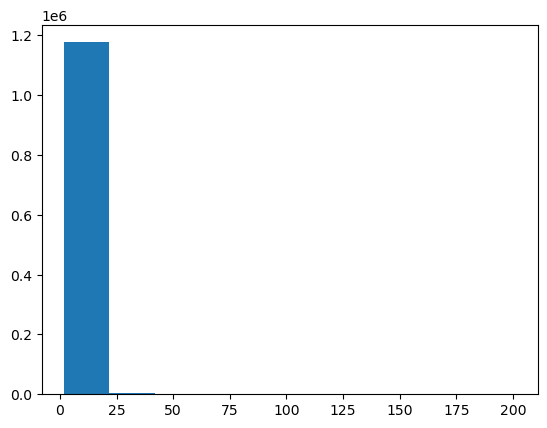

In [ ]:
plt.hist(sessions_uk['prev_items_len'])

(array([1.140282e+06, 3.701000e+04, 3.964000e+03, 6.560000e+02,
        1.830000e+02, 5.500000e+01, 8.000000e+00, 1.500000e+01,
        4.000000e+00, 2.000000e+00]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

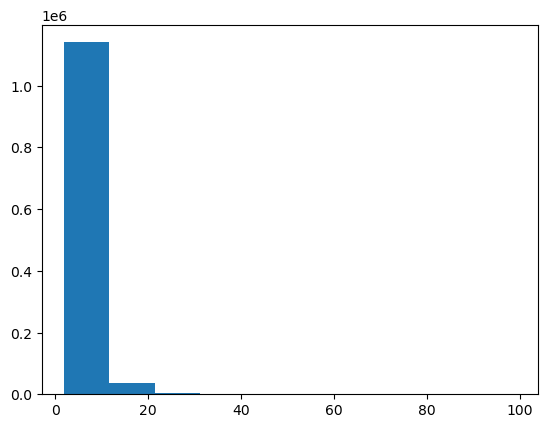

In [ ]:
plt.hist(sessions_uk.loc[sessions_uk['prev_items_len']<100]['prev_items_len'])

(array([9.48394e+05, 1.63263e+05, 4.48340e+04, 1.25340e+04, 7.23200e+03,
        3.06900e+03, 1.09100e+03, 8.39000e+02, 3.88000e+02, 2.27000e+02]),
 array([ 2. ,  5.7,  9.4, 13.1, 16.8, 20.5, 24.2, 27.9, 31.6, 35.3, 39. ]),
 <BarContainer object of 10 artists>)

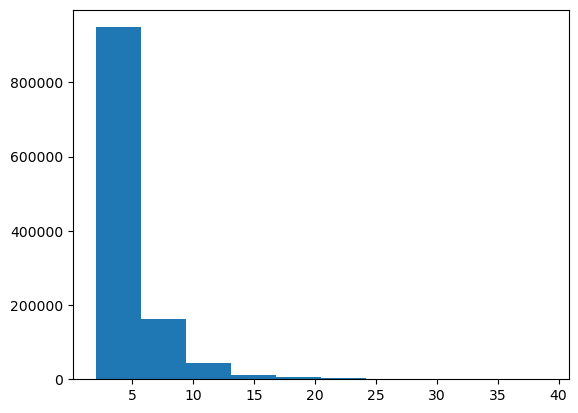

In [ ]:
plt.hist(sessions_uk.loc[sessions_uk['prev_items_len']<40]['prev_items_len'])

(array([698169., 250225., 109462.,  31348.,  38940.,  21382.,   6965.,
          9345.,   5704.,   3481.]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ]),
 <BarContainer object of 10 artists>)

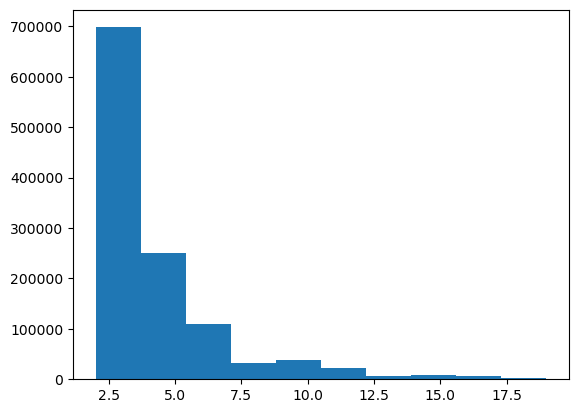

In [ ]:
plt.hist(sessions_uk.loc[sessions_uk['prev_items_len']<20]['prev_items_len'])

# Data Cleaning

Unused for now, we'll have to decide what to do about each column

I think the first step may be to remove the super expensive products and see if anything else changes

## Filter

to keep target rows

### filter locale

In [ ]:
products_uk.shape

(500180, 11)

In [ ]:
sessions_uk.shape

(1182181, 4)

### filter price

(array([474900.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  25280.]),
 array([       0.   ,  4000000.007,  8000000.014, 12000000.021,
        16000000.028, 20000000.035, 24000000.042, 28000000.049,
        32000000.056, 36000000.063, 40000000.07 ]),
 <BarContainer object of 10 artists>)

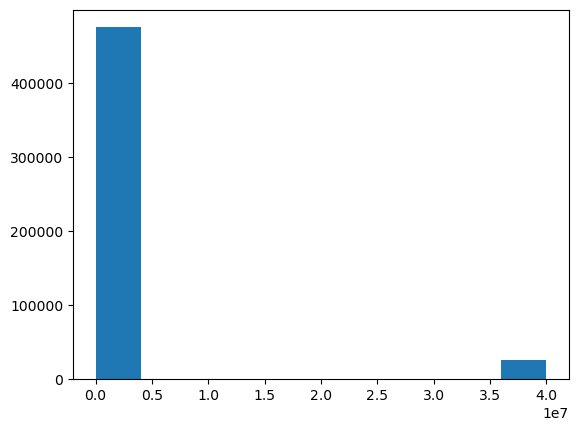

In [ ]:
plt.hist(products_uk['price'])

If we take the limit for "price", there will be -38230 rows filtered out.
Number of rows are left:  461950



(array([193735., 157368.,  59807.,  23295.,  10546.,   6000.,   4048.,
          2872.,   2297.,   1982.]),
 array([ 0.   ,  9.999, 19.998, 29.997, 39.996, 49.995, 59.994, 69.993,
        79.992, 89.991, 99.99 ]),
 <BarContainer object of 10 artists>)

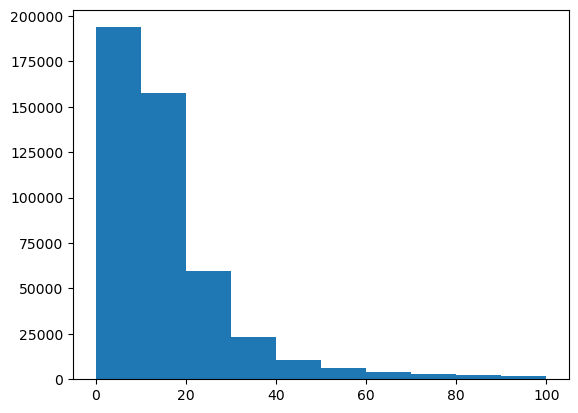

In [ ]:
del_rows_num = len(products_uk.loc[products_uk['price']<100]['price']) - products_uk.shape[0]
print(f'If we take the limit for "price", there will be {del_rows_num} rows filtered out.')
print(f'Number of rows are left: ', len(products_uk.loc[products_uk['price']<100]['price']))
print()
plt.hist(products_uk.loc[products_uk['price']<100]['price'])

### filter brand

5-10 is good.

In [ ]:
sum(products_uk['brand'].notnull())

495900

In [ ]:
brand_counts = products_uk['brand'].value_counts()
brand_counts

Generic            2283
L'Oreal            1508
Amazon Basics      1402
LEGO               1335
Morrisons          1287
                   ... 
Bookends2pairUK       1
Lipton Iced Tea       1
Q&K                   1
HULY                  1
CRYSTALS              1
Name: brand, Length: 76349, dtype: int64

In [ ]:
brand_counts[brand_counts > 100]

Generic          2283
L'Oreal          1508
Amazon Basics    1402
LEGO             1335
Morrisons        1287
                 ... 
ORETECH           101
Olay              101
Pecute            101
JUSTOTRY          101
POPRUN            101
Name: brand, Length: 439, dtype: int64

In [ ]:
brand_counts[brand_counts > 1000]

Generic                    2283
L'Oreal                    1508
Amazon Basics              1402
LEGO                       1335
Morrisons                  1287
Independently published    1191
Apple                      1033
Name: brand, dtype: int64

In [ ]:
min_limit = 5

brand_name = brand_counts[brand_counts > min_limit].index.tolist()
brand_value = brand_counts[brand_counts > min_limit].values

print(brand_name)
print(brand_value)
print('Number of brands are included: ', len(brand_name))
print('Number of rows are included: ', sum(brand_value))

['Generic', "L'Oreal", 'Amazon Basics', 'LEGO', 'Morrisons', 'Independently published', 'Apple', 'Samsung', 'Coty', "Smiffy's", 'JETech', 'I LOVE FANCY DRESS LTD', 'Audible', 'Amazon EU Sarl', 'Amazon', 'Coordination Group Publications Ltd (CGP)', 'Philips', 'Anker', 'Spigen', 'Hasbro', 'Eono', 'Bosch', 'Penguin', 'amscan', '3M', 'Russell Hobbs', 'Stuff4', 'KW-Commerce', 'Amscan', 'Vicloon', 'HENBRANDT', 'kuou', "Rubie's", 'Wicked Costumes', 'SONGMICS', 'Ravensburger', 'Newell Brands', 'Oral-B', 'UK Greetings', 'HOMCOM', 'Yaheetech', 'Collins', 'Barbie', 'GC GAVENO CAVAILIA', 'MiniSun', 'Bedshe', 'BLUESKY', 'Logitech', 'Deconovo', 'MYLEE', 'Silentnight', 'VEYLIN', 'Disney', 'Hallmark', 'Garnier', 'Tower', 'Addis', 'Baker Ross', 'Nintendo', 'Mattel', 'Funko', 'Stanley', 'ANSIO', 'HP', 'ORNARTO', 'Melissa & Doug', 'Sleepdown', 'Mayborn Group', 'UGREEN', 'HarperCollins', 'MAM', 'Draper', 'TP-Link', 'MoKo', 'OtterBox', 'JOYIN', 'Brabantia', 'Everbuild', 'Amazon EU S.à.r.l.', 'Playmobil', '

In [ ]:
min_limit = 10

brand_name = brand_counts[brand_counts > min_limit].index.tolist()
brand_value = brand_counts[brand_counts > min_limit].values

print(brand_name)
print(brand_value)
print('Number of brands are included: ', len(brand_name))
print('Number of rows are included: ', sum(brand_value))

['Generic', "L'Oreal", 'Amazon Basics', 'LEGO', 'Morrisons', 'Independently published', 'Apple', 'Samsung', 'Coty', "Smiffy's", 'JETech', 'I LOVE FANCY DRESS LTD', 'Audible', 'Amazon EU Sarl', 'Amazon', 'Coordination Group Publications Ltd (CGP)', 'Philips', 'Anker', 'Spigen', 'Hasbro', 'Eono', 'Bosch', 'Penguin', 'amscan', '3M', 'Russell Hobbs', 'Stuff4', 'KW-Commerce', 'Amscan', 'Vicloon', 'HENBRANDT', 'kuou', "Rubie's", 'Wicked Costumes', 'SONGMICS', 'Ravensburger', 'Newell Brands', 'Oral-B', 'UK Greetings', 'HOMCOM', 'Yaheetech', 'Collins', 'Barbie', 'GC GAVENO CAVAILIA', 'MiniSun', 'Bedshe', 'BLUESKY', 'Logitech', 'Deconovo', 'MYLEE', 'Silentnight', 'VEYLIN', 'Disney', 'Hallmark', 'Garnier', 'Tower', 'Addis', 'Baker Ross', 'Nintendo', 'Mattel', 'Funko', 'Stanley', 'ANSIO', 'HP', 'ORNARTO', 'Melissa & Doug', 'Sleepdown', 'Mayborn Group', 'UGREEN', 'HarperCollins', 'MAM', 'Draper', 'TP-Link', 'MoKo', 'OtterBox', 'JOYIN', 'Brabantia', 'Everbuild', 'Amazon EU S.à.r.l.', 'Playmobil', '

### filter color

In [ ]:
sum(products_uk['color'].notnull())

378080

In [ ]:
color_counts = products_uk['color'].value_counts()
color_counts

Black                         56750
White                         33187
Blue                          15002
Grey                          11594
Silver                        10344
                              ...  
Warm White(3m*2m)                 1
Big Tray + Blue Mat               1
B-bead Dark Pink                  1
Four-Leaf Clover Bowl Blue        1
Deep Grey Yuki                    1
Name: color, Length: 72069, dtype: int64

In [ ]:
min_limit = 5

color_name = color_counts[color_counts > min_limit].index.tolist()
color_value = color_counts[color_counts > min_limit].values

print(color_name)
print(color_value)
print('Number of colors are included: ', len(color_name))
print('Number of rows are included: ', sum(color_value))

['Black', 'White', 'Blue', 'Grey', 'Silver', 'Multicolor', 'Red', 'Pink', 'Green', 'Clear', 'Brown', 'Transparent', 'Purple', 'Gold', 'Yellow', 'Orange', 'Beige', 'Multicoloured', 'Multi', 'black', 'Warm White', 'Gray', 'Multicolour', 'Rose Gold', 'Assorted', 'white', 'Navy', 'Dark Grey', 'Cream', 'Natural', 'Navy Blue', 'Chrome', 'Multi-colour', 'A', 'Light Grey', 'Cool White', 'BLACK', 'blue', 'Charcoal', 'Multi-coloured', 'Multi-colored', 'As Shown', 'Rainbow', 'Light Blue', 'Stainless Steel', 'Dark Blue', 'Mixed', 'Other', 'Ivory', 'Multicolored', 'transparent', 'Dark Green', 'Teal', 'WHITE', 'Colorful', '1', 'red', 'Dark Brown', 'B', 'Rose', 'clear', 'Various', 'pink', 'silver', 'Light Brown', 'Matte Black', 'grey', 'Burgundy', 'Bronze', 'Turquoise', 'Wood', 'Copper', 'green', 'brown', 'Graphite', 'Coffee', 'Silver Grey', 'Sky Blue', 'Blush Pink', 'multicolor', 'Multi Coloured', 'Black/White', 'Aqua', 'Khaki', 'Assorted Colours', 'Sliver', 'Baby Pink', 'Colourful', 'multicoloured'

In [ ]:
min_limit = 100

color_name = color_counts[color_counts > min_limit].index.tolist()
color_value = color_counts[color_counts > min_limit].values

print(color_name)
print(color_value)
print('Number of colors are included: ', len(color_name))
print('Number of rows are included: ', sum(color_value))

['Black', 'White', 'Blue', 'Grey', 'Silver', 'Multicolor', 'Red', 'Pink', 'Green', 'Clear', 'Brown', 'Transparent', 'Purple', 'Gold', 'Yellow', 'Orange', 'Beige', 'Multicoloured', 'Multi', 'black', 'Warm White', 'Gray', 'Multicolour', 'Rose Gold', 'Assorted', 'white', 'Navy', 'Dark Grey', 'Cream', 'Natural', 'Navy Blue', 'Chrome', 'Multi-colour', 'A', 'Light Grey', 'Cool White', 'BLACK', 'blue', 'Charcoal', 'Multi-coloured', 'Multi-colored', 'As Shown', 'Rainbow', 'Light Blue', 'Stainless Steel', 'Dark Blue', 'Mixed', 'Other', 'Ivory', 'Multicolored', 'transparent', 'Dark Green', 'Teal', 'WHITE', 'Colorful', '1', 'red', 'Dark Brown', 'B', 'Rose', 'clear', 'Various', 'pink', 'silver', 'Light Brown', 'Matte Black', 'grey', 'Burgundy', 'Bronze', 'Turquoise', 'Wood', 'Copper', 'green', 'brown', 'Graphite', 'Coffee', 'Silver Grey', 'Sky Blue', 'Blush Pink', 'multicolor', 'Multi Coloured', 'Black/White', 'Aqua', 'Khaki', 'Assorted Colours', 'Sliver', 'Baby Pink', 'Colourful', 'multicoloured'

In [ ]:
min_limit = 500

color_name = color_counts[color_counts > min_limit].index.tolist()
color_value = color_counts[color_counts > min_limit].values

print(color_name)
print(color_value)
print('Number of colors are included: ', len(color_name))
print('Number of rows are included: ', sum(color_value))

['Black', 'White', 'Blue', 'Grey', 'Silver', 'Multicolor', 'Red', 'Pink', 'Green', 'Clear', 'Brown', 'Transparent', 'Purple', 'Gold', 'Yellow', 'Orange', 'Beige', 'Multicoloured', 'Multi', 'black', 'Warm White', 'Gray', 'Multicolour', 'Rose Gold', 'Assorted', 'white', 'Navy', 'Dark Grey', 'Cream', 'Natural', 'Navy Blue', 'Chrome', 'Multi-colour', 'A', 'Light Grey', 'Cool White', 'BLACK', 'blue', 'Charcoal']
[56750 33187 15002 11594 10344 10153  8294  7902  7832  6956  6091  3664
  3512  3294  3053  2716  2605  2569  2148  1973  1836  1642  1376  1301
  1213  1176  1032  1007   960   955   775   756   683   661   648   608
   606   563   507]
Number of colors are included:  39
Number of rows are included:  217944


### filter size

### filter model

### filter material

In [ ]:
sum(products_uk['material'].notnull())

298955

In [ ]:
material_counts = products_uk['material'].value_counts()
material_counts

Plastic                    42638
Metal                      13343
Polyester                  13080
Stainless Steel            10226
Paper                      10029
                           ...  
Gel, Silicone                  1
Polyester + Magnet             1
essential oil set              1
tissue paper                   1
Aluminium,Plastic,Resin        1
Name: material, Length: 14775, dtype: int64

In [ ]:
min_limit = 500

material_name = material_counts[material_counts > min_limit].index.tolist()
material_value = material_counts[material_counts > min_limit].values

print(material_name)
print(material_value)
print('Number of materials are included: ', len(material_name))
print('Number of rows are included: ', sum(material_value))

['Plastic', 'Metal', 'Polyester', 'Stainless Steel', 'Paper', 'Cotton', 'Silicone', 'Wood', 'Aluminium', 'Rubber', 'Glass', 'Nylon', 'Acrylonitrile Butadiene Styrene', 'Alloy Steel', 'Acrylic', 'Faux Leather', 'Cardboard', 'Leather', 'Polypropylene', '100% Polyester', 'Polycarbonate', 'Polyvinyl Chloride', 'Ceramic', 'Copper', 'Synthetic', 'Vinyl', 'Foam', 'Engineered Wood', 'Thermoplastic Polyurethane', 'Tempered Glass', 'Fabric', 'Wax', '100% Cotton', 'plastic', 'Iron', 'ABS', 'Microfiber', 'Crystal', 'Resin', 'Neoprene', 'Ethylene Vinyl Acetate', 'PVC', 'Silk', 'Aluminum', 'Fleece', 'Carbon Steel', 'Memory Foam', 'Steel', 'Brass', 'Canvas', 'Polyethylene', 'Bamboo', 'Linen', 'Silver', 'Polyurethane', 'Faux Fur', 'Plush', 'Microfibre', 'Cardstock', 'Satin', 'Velvet', 'Soy Wax', 'Polyethylene Terephthalate', 'Sterling Silver', 'polyester', 'Felt', 'Zinc']
[42638 13343 13080 10226 10029  9552  8508  7166  6752  6716  6003  5430
  5042  4833  4289  4190  4102  3533  3444  3158  3129  30

In [ ]:
products_uk.loc[products_uk['price']> ]

SyntaxError: invalid syntax (2849808403.py, line 1)

# Data Wangling